In [ ]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
#!pip list
#!pip show category_encoders
%pip install category_encoders


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, -1, Cancelled, , Cancelled)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import count, avg, col
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, -1, Cancelled, , Cancelled)

Crea las transformaciones en tablas para materializar las vistas

In [ ]:
df = spark.sql("""
    SELECT
        Codigo,
        Descripcion,
        Clasificacion,
        CASE
            WHEN Clasificacion IS NULL THEN 0
            ELSE 1
        END AS ClasificacionCod
    FROM DemoLakeHouseYuly.manual_motor
""")
df.write.format("delta").mode("overwrite").save("Tables/MAT_manual_motorLimpio")

df = spark.sql("""
   select   distinct serie,   data_name,  unidad, valor, smr_value,  fecha
   from DemoLakeHouseYuly.`telemetría1`
""")
df.write.format("delta").mode("overwrite").save("Tables/MAT_telemetriaLimpio")

df = spark.sql("""
    SELECT
    Equipo,
    `código` ,
    TO_TIMESTAMP(startlocal, 'M/d/yyyy H:mm') AS startlocal,
    TO_TIMESTAMP(endlocal, 'M/d/yyyy H:mm') AS endlocal,
    comentario
FROM mnp_potencia;
""")

# Renombrar la columna en PySpark
df = df.withColumnRenamed("código", "codigo")  # Usando comillas invertidas
print(df.columns)

df.write.format("delta").mode("overwrite").save("Tables/MAT_mnp_potenciaLimpio")

df = spark.sql("""
    select a.serie, a.codigo, a.descripcion, a.fecha1, a.valor1 , a.cont, b.Clasificacion, b.ClasificacionCod
    from  DemoLakeHouseYuly.alertas a
    inner join DemoLakeHouseYuly.MAT_manual_motorLimpio b on a.codigo = b.Codigo
""")
df.write.format("delta").mode("overwrite").save("Tables/MAT_alertasLimpio")


df = spark.sql("""
    WITH CTE AS (
        SELECT
            Equipo,
            codigo,
            startlocal,
            LAG(startlocal) OVER (PARTITION BY Equipo ORDER BY startlocal) AS startlocalAnt
        FROM DemoLakeHouseYuly.MAT_mnp_potenciaLimpio
    )
    SELECT
        c.Equipo,
        c.codigo AS codMantenimiento,
        c.startlocal AS fechaIniDetension,
        b.codigo AS codAlerta,
        b.descripcion AS descAlerta,
        b.fecha1 AS fechaAlerta,
        b.valor1 AS horoEquipo,
        b.cont AS vecesAlerta,
        b.Clasificacion AS gravedadAlerta,
        DATEDIFF(DAY, b.fecha1, c.startlocal) AS diasParaDetension
    FROM CTE c
    INNER JOIN DemoLakeHouseYuly.MAT_alertasLimpio b
        ON b.serie = c.Equipo
        AND b.fecha1 > c.startlocalAnt
        AND b.fecha1 <= c.startlocal
""")

df.write.format("delta").mode("overwrite").save("Tables/MAT_alertasPrevioDetension")

df = spark.sql("""
    WITH CTE AS (
        SELECT
            Equipo,
            codigo,
            startlocal,
            LAG(startlocal) OVER (PARTITION BY Equipo ORDER BY startlocal) AS startlocalAnt
        FROM DemoLakeHouseYuly.MAT_mnp_potenciaLimpio
    )
    SELECT
		c.Equipo,	c.codigo as codMantenimiento,	c.startlocal as fechaIniDetension,
		b.data_name as telemetria,	 b.fecha as fechaTelemetria,
		b.smr_value as horoEquipo , b.valor as valorTele ,
		datediff(day,   b.fecha, c.startlocal) as diasParaDetension
	FROM CTE c
	INNER JOIN DemoLakeHouseYuly.MAT_telemetriaLimpio b
		ON b.serie = c.Equipo
		and b.fecha >  c.startlocalAnt
    AND b.fecha <= c.startlocal
""")

df.write.format("delta").mode("overwrite").save("Tables/MAT_telemetriasPrevioDetension")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, -1, Cancelled, , Cancelled)

Carga de datos para el algoritmo

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import count, avg, col
from pyspark.ml.feature import StringIndexer
from pyspark.sql.window import Window


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 63, Finished, Available, Finished)

In [ ]:
# Cargar Datos
df_alertas = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_alertasPrevioDetension")
df_telemetria = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_telemetriasPrevioDetension")



StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 64, Finished, Available, Finished)

In [ ]:
df_alertas.printSchema()

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 65, Finished, Available, Finished)

root
 |-- Equipo: string (nullable = true)
 |-- codMantenimiento: string (nullable = true)
 |-- fechaIniDetension: timestamp (nullable = true)
 |-- codAlerta: string (nullable = true)
 |-- descAlerta: string (nullable = true)
 |-- fechaAlerta: timestamp (nullable = true)
 |-- horoEquipo: double (nullable = true)
 |-- vecesAlerta: integer (nullable = true)
 |-- gravedadAlerta: string (nullable = true)
 |-- diasParaDetension: long (nullable = true)



In [ ]:
df_telemetria.printSchema()

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 66, Finished, Available, Finished)

root
 |-- Equipo: string (nullable = true)
 |-- codMantenimiento: string (nullable = true)
 |-- fechaIniDetension: timestamp (nullable = true)
 |-- telemetria: string (nullable = true)
 |-- fechaTelemetria: timestamp (nullable = true)
 |-- horoEquipo: double (nullable = true)
 |-- valorTele: double (nullable = true)
 |-- diasParaDetension: long (nullable = true)



In [ ]:
df_alertas.show(5)

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 67, Finished, Available, Finished)

+------+--------------------+-------------------+---------+--------------------+-------------------+----------+-----------+--------------+-----------------+
|Equipo|    codMantenimiento|  fechaIniDetension|codAlerta|          descAlerta|        fechaAlerta|horoEquipo|vecesAlerta|gravedadAlerta|diasParaDetension|
+------+--------------------+-------------------+---------+--------------------+-------------------+----------+-----------+--------------+-----------------+
|  C307|MANTENCION NO PRO...|2021-07-14 11:06:00|     C112|Timing Fueling Mi...|2021-06-09 00:20:49|   41975.3|         14|          NULL|               35|
|  C322|MANTENCION NO PRO...|2021-05-18 11:28:00|     C612|High Oil Filter Rest|2021-05-18 11:21:53|   35588.2|         14|          NULL|                0|
|  C333|MANTENCION NO PRO...|2022-04-23 03:51:00|     C147|Freq Throttle OOR...|2022-03-21 05:38:24|   17309.0|          9|          NULL|               32|
|  C327|MANTENCION NO PRO...|2021-11-13 07:29:00|     C452

In [ ]:
# Cargar Datos
df_alertas = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_alertasPrevioDetension")
df_telemetria = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_telemetriasPrevioDetension")

# Convertir DataFrames de Spark a pandas
df_alertas_pd = df_alertas.toPandas()
df_telemetria_pd = df_telemetria.toPandas()

# Eliminar columnas de fecha en df_alertas
df_alertas = df_alertas.drop("fechaIniDetension", "fechaAlerta")

# Eliminar columnas de fecha en df_telemetria
df_telemetria = df_telemetria.drop("fechaIniDetension", "fechaTelemetria")

df = df_alertas.join(df_telemetria,
                     on=["Equipo", "horoEquipo", "diasParaDetension", "codMantenimiento"],
                     how="outer")


# Limpieza de Datos
#elimina datos duplicados
df = df.dropDuplicates() ##DAdo que son inmutables se tiene que asignar

df = df.fillna({
    "gravedadAlerta": "SinDato",
    "codAlerta": "SinAlerta",
    "telemetria": "SinTelemetria",
    "valorTele": 0
})

# Se ordena el dataset por equipo y horoequipo
df = df.orderBy(["Equipo", "horoEquipo"])


#Se generan nuevas columnas con valores calculados en una ventana de los ultimos 5 registros por equipos
# Definir la ventana de 5 registros por cada "Equipo", ordenada por algún criterio (ej. timestamp o índice)
window_spec = Window.partitionBy("Equipo").orderBy("horoEquipo").rowsBetween(-4, 0)

# Calcular el conteo de alertas en los últimos 5 registros
df = df.withColumn("alertas_ultimos_5reg", count("codAlerta").over(window_spec))

# Calcular el promedio de "valorTele" en los últimos 5 registros
df = df.withColumn("promedio_telemetria_5reg", avg("valorTele").over(window_spec))
# Aplicar Label Encoding en lugar de Target Encoding
#Transformación de variables categoricas - se convierten las variables categroicas en valores numericas mediante LabelEncoder()
#lo q asigna un numero a cada categoria distinta

categorical_cols = ["codMantenimiento", "codAlerta", "gravedadAlerta", "telemetria"]
categorical_cols = [col for col in categorical_cols if col in df.columns]  # Filtrar columnas existentes

# Aplicar StringIndexer a cada columna categórica
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)




StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 68, Finished, Available, Finished)

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 95, Finished, Available, Finished)

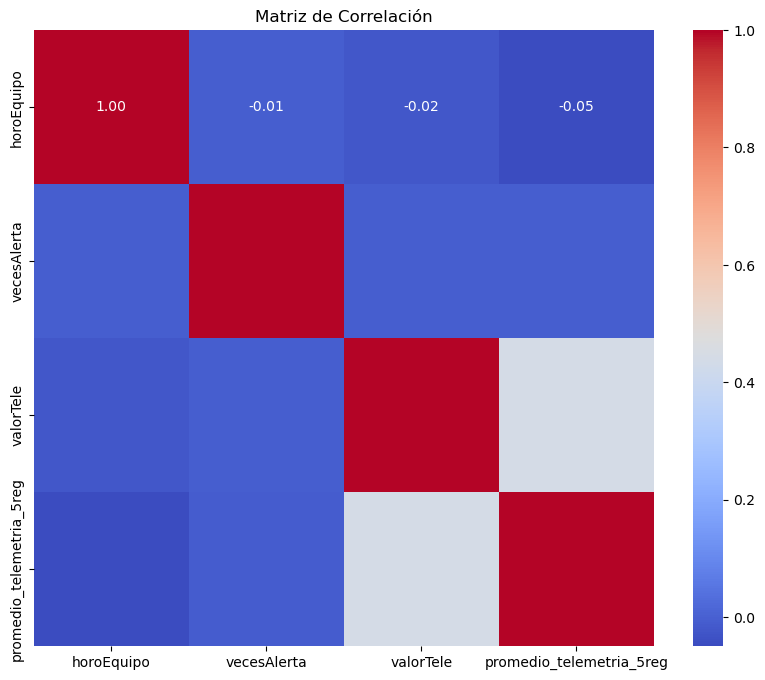

Procesamiento finalizado. dataSet guardado en tabla 'dataset_procesado'
+------+----------+-----------------+--------------------+---------+-----------+--------------+----------------+---------+--------------------+------------------------+
|Equipo|horoEquipo|diasParaDetension|    codMantenimiento|codAlerta|vecesAlerta|gravedadAlerta|      telemetria|valorTele|alertas_ultimos_5reg|promedio_telemetria_5reg|
+------+----------+-----------------+--------------------+---------+-----------+--------------+----------------+---------+--------------------+------------------------+
|  C301|   36880.9|               13|MANTENCION NO PRO...|     C112|          1|       SinDato|   SinTelemetria|      0.0|                   1|                     0.0|
|  C301|   36881.3|               13|MANTENCION NO PRO...|     C112|          1|       SinDato|   SinTelemetria|      0.0|                   2|                     0.0|
|  C301|   37205.2|               40|MANTENCION NO PRO...|     C112|          1|   

In [ ]:

numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ["int", "double"]]

# Calcular matriz de correlación manualmente
corr_matrix = []
for col1 in numeric_cols:
    row = []
    for col2 in numeric_cols:
        corr_value = df.stat.corr(col1, col2)  # Calcular correlación entre pares de columnas
        row.append(corr_value)
    corr_matrix.append(row)

# Convertir a DataFrame de Pandas para graficar
corr_df = pd.DataFrame(corr_matrix, columns=numeric_cols, index=numeric_cols)

# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

# Guardar Dataset Final
df.write.format("delta").mode("overwrite").save("Tables/dataset_procesado")
print("Procesamiento finalizado. dataSet guardado en tabla 'dataset_procesado'")


df.show(5)  # Mostrar las primeras 5 filas


In [ ]:
#df.write.mode("overwrite").option("header", True).csv("Files/dataset_procesado")

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 70, Finished, Available, Finished)

In [ ]:
df.show(5)

StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 71, Finished, Available, Finished)

+------+----------+-----------------+--------------------+---------+--------------------+-----------+--------------+----------------+---------+--------------------+------------------------+----------------------+---------------+--------------------+----------------+
|Equipo|horoEquipo|diasParaDetension|    codMantenimiento|codAlerta|          descAlerta|vecesAlerta|gravedadAlerta|      telemetria|valorTele|alertas_ultimos_5reg|promedio_telemetria_5reg|codMantenimiento_index|codAlerta_index|gravedadAlerta_index|telemetria_index|
+------+----------+-----------------+--------------------+---------+--------------------+-----------+--------------+----------------+---------+--------------------+------------------------+----------------------+---------------+--------------------+----------------+
|  C301|   36880.9|               13|MANTENCION NO PRO...|     C112|Timing Fueling Mi...|          1|       SinDato|   SinTelemetria|      0.0|                   1|                     0.0|          

In [ ]:
'''from pyspark.sql import SparkSession

# Leer el DataFrame desde la consulta SQL
df = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_telemetriasPrevioDetension")

# Guardar temporalmente en una carpeta dentro de 'Files/Resultado'
temp_path = "Files/Resultado/temp_telemetriasPrevioDetension"

df.write.mode("overwrite").option("header", True).csv(temp_path)

# Unir los archivos en un solo CSV con un nombre específico
output_path = "Files/Resultado/telemetriasPrevioDetension.csv"

# Usar Fabric Utilities para mover y renombrar el archivo (si estás en Fabric Notebooks)
import os
os.system(f"mv {temp_path}/part-*.csv {output_path}")
os.system(f"rm -r {temp_path}")  # Eliminar la carpeta temporal'''


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 72, Finished, Available, Finished)

'from pyspark.sql import SparkSession\n\n# Leer el DataFrame desde la consulta SQL\ndf = spark.sql("SELECT * FROM DemoLakeHouseYuly.MAT_telemetriasPrevioDetension")\n\n# Guardar temporalmente en una carpeta dentro de \'Files/Resultado\'\ntemp_path = "Files/Resultado/temp_telemetriasPrevioDetension"\n\ndf.write.mode("overwrite").option("header", True).csv(temp_path)\n\n# Unir los archivos en un solo CSV con un nombre específico\noutput_path = "Files/Resultado/telemetriasPrevioDetension.csv"\n\n# Usar Fabric Utilities para mover y renombrar el archivo (si estás en Fabric Notebooks)\nimport os\nos.system(f"mv {temp_path}/part-*.csv {output_path}")\nos.system(f"rm -r {temp_path}")  # Eliminar la carpeta temporal'

Graba una tabla desde un dataFrame

In [ ]:
#df.write.format("delta").mode("overwrite").save("Tables/alertasPrevioDetension_MAT")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 73, Finished, Available, Finished)

In [ ]:
#Eliminando columna descripcion de alerta por no ser relevante en el estudio

df=df.drop("descAlerta")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 74, Finished, Available, Finished)

In [ ]:
# Ver cuántos valores nulos hay por columna
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 75, Finished, Available, Finished)

+------+----------+-----------------+----------------+---------+-----------+--------------+----------+---------+--------------------+------------------------+----------------------+---------------+--------------------+----------------+
|Equipo|horoEquipo|diasParaDetension|codMantenimiento|codAlerta|vecesAlerta|gravedadAlerta|telemetria|valorTele|alertas_ultimos_5reg|promedio_telemetria_5reg|codMantenimiento_index|codAlerta_index|gravedadAlerta_index|telemetria_index|
+------+----------+-----------------+----------------+---------+-----------+--------------+----------+---------+--------------------+------------------------+----------------------+---------------+--------------------+----------------+
|     0|         0|                0|               0|        0|     278852|             0|         0|        0|                   0|                       0|                     0|              0|                   0|               0|
+------+----------+-----------------+----------------+--

In [ ]:
print(df.columns)


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 76, Finished, Available, Finished)

['Equipo', 'horoEquipo', 'diasParaDetension', 'codMantenimiento', 'codAlerta', 'vecesAlerta', 'gravedadAlerta', 'telemetria', 'valorTele', 'alertas_ultimos_5reg', 'promedio_telemetria_5reg', 'codMantenimiento_index', 'codAlerta_index', 'gravedadAlerta_index', 'telemetria_index']


In [ ]:
df = df.drop("codMantenimiento_index", "codAlerta_index", "gravedadAlerta_index", "telemetria_index")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 77, Finished, Available, Finished)

In [ ]:
print(df.columns)


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 78, Finished, Available, Finished)

['Equipo', 'horoEquipo', 'diasParaDetension', 'codMantenimiento', 'codAlerta', 'vecesAlerta', 'gravedadAlerta', 'telemetria', 'valorTele', 'alertas_ultimos_5reg', 'promedio_telemetria_5reg']


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 79, Finished, Available, Finished)

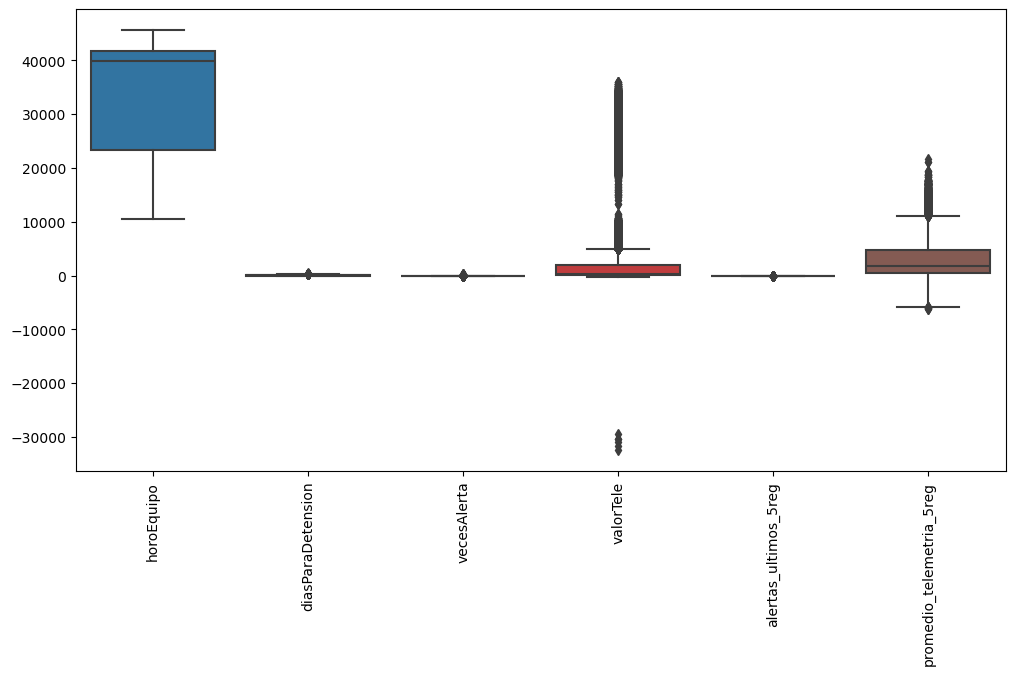

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ["int", "double", "bigint"]]
df_pandas = df.select(numeric_cols).toPandas()

# Graficar boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pandas)
plt.xticks(rotation=90)
plt.show()


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 80, Finished, Available, Finished)

🔄 Entrenando Random Forest con PCA...


🔄 Entrenando Regresión Lineal con PCA...


🔄 Entrenando Decision Tree con PCA...


🔄 Entrenando Gradient Boosted Trees con PCA...



Comparación de Modelos - Métricas de Precisión:
                              MAE         MSE        R2
Gradient Boosted Trees   7.496940  124.793604  0.961406
Regresión Lineal         8.892161  173.525693  0.946281
Decision Tree            9.685624  175.122132  0.945828
Random Forest           13.847898  308.199277  0.904570


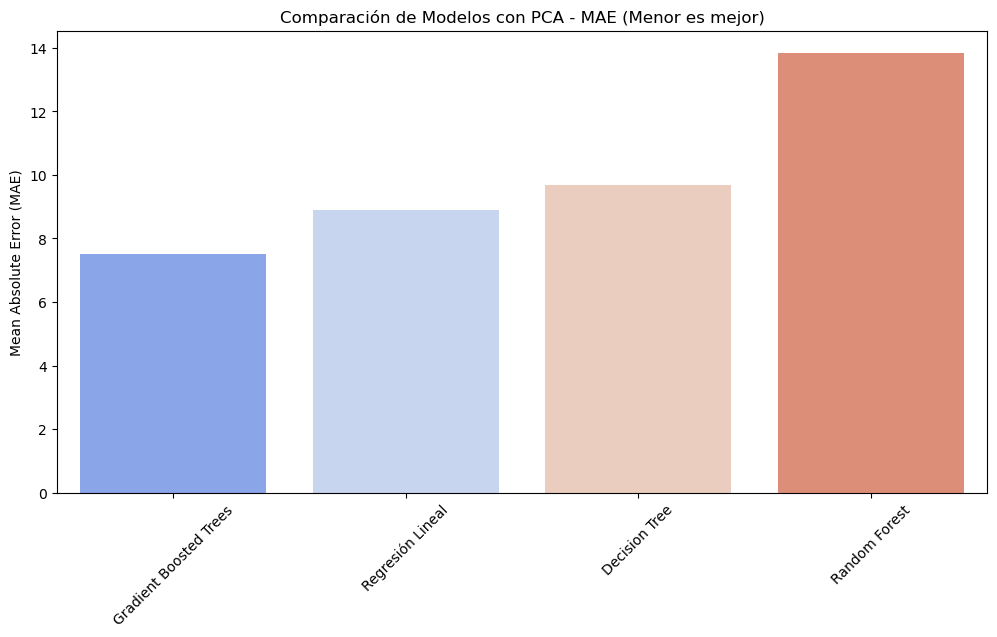

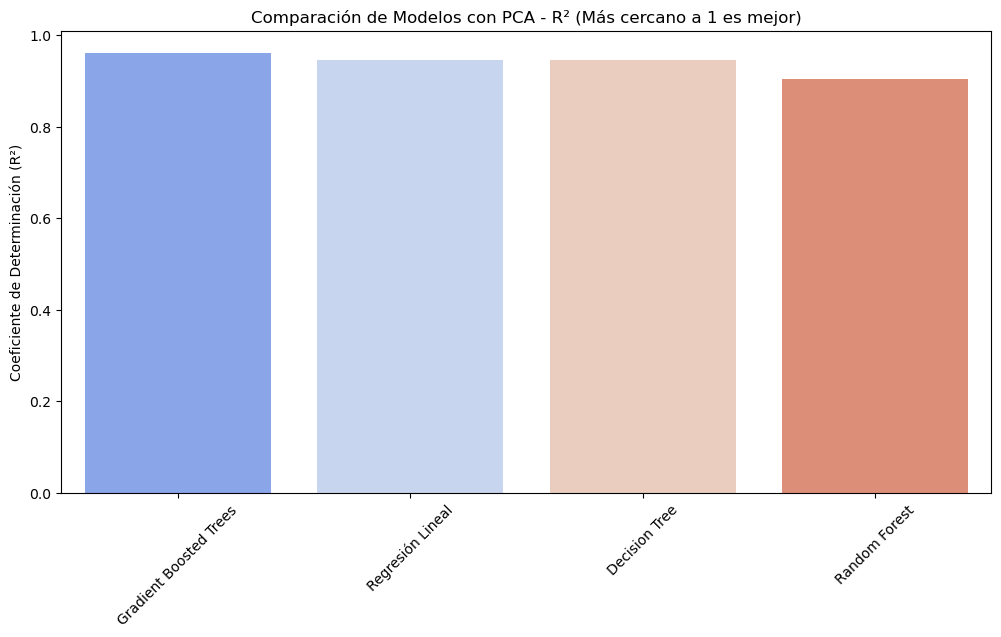

In [ ]:
# Importar las librerías necesarias
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer, PCA
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear la sesión de Spark
spark = SparkSession.builder.appName("ModelComparison_PCA").getOrCreate()

df_spark = df

# Eliminar columnas no relevantes
cols_to_drop = ["descAlerta"]
df_spark = df_spark.drop(*cols_to_drop)

target_col = "diasParaDetension"
feature_cols = [col for col in df_spark.columns if col != target_col]

# Identificar variables numéricas y categóricas
num_cols = [col for col, dtype in df_spark.dtypes if dtype in ("int", "double")]
cat_cols = [col for col, dtype in df_spark.dtypes if dtype not in ("int", "double")]

# Imputación de valores faltantes
for col_name in num_cols:
    mean_value = df_spark.selectExpr(f"mean({col_name}) as mean").collect()[0]["mean"]
    df_spark = df_spark.fillna({col_name: mean_value})

for col_name in cat_cols:
    mode_value = df_spark.groupBy(col_name).count().orderBy(col("count").desc()).first()[0]
    df_spark = df_spark.fillna({col_name: mode_value})

# Indexar variables categóricas
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_idx").fit(df_spark) for col_name in cat_cols]
for indexer in indexers:
    df_spark = indexer.transform(df_spark)

feature_cols = [col for col in feature_cols if col not in cat_cols] + [f"{col}_idx" for col in cat_cols]

# Vectorizar características
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_spark = assembler.transform(df_spark)

# Aplicar PCA
num_pca_components = 5
pca = PCA(k=num_pca_components, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_spark)
df_spark = pca_model.transform(df_spark)

# Dividir en datos de entrenamiento y prueba
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)

# Modelos a evaluar
models = {
    "Random Forest": RandomForestRegressor(featuresCol="pca_features", labelCol=target_col, maxBins=300),
    "Regresión Lineal": LinearRegression(featuresCol="pca_features", labelCol=target_col),
    "Decision Tree": DecisionTreeRegressor(featuresCol="pca_features", labelCol=target_col),
    "Gradient Boosted Trees": GBTRegressor(featuresCol="pca_features", labelCol=target_col, maxIter=100)
}

# Evaluar los modelos
results = {}

for name, model in models.items():
    print(f"🔄 Entrenando {name} con PCA...")
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)

    # Evaluadores
    mae_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mae")
    mse_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="mse")
    r2_evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")

    # Cálculo de métricas
    mae = mae_evaluator.evaluate(predictions)
    mse = mse_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)

    results[name] = {"MAE": mae, "MSE": mse, "R2": r2}

# Convertir resultados a DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results.sort_values(by="MAE")

# Imprimir métricas
print("\nComparación de Modelos - Métricas de Precisión:")
print(df_results)

# Graficar resultados
plt.figure(figsize=(12, 6))
sns.barplot(x=df_results.index, y=df_results["MAE"], palette="coolwarm")
plt.title("Comparación de Modelos con PCA - MAE (Menor es mejor)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=df_results.index, y=df_results["R2"], palette="coolwarm")
plt.title("Comparación de Modelos con PCA - R² (Más cercano a 1 es mejor)")
plt.ylabel("Coeficiente de Determinación (R²)")
plt.xticks(rotation=45)
plt.show()


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 81, Finished, Available, Finished)

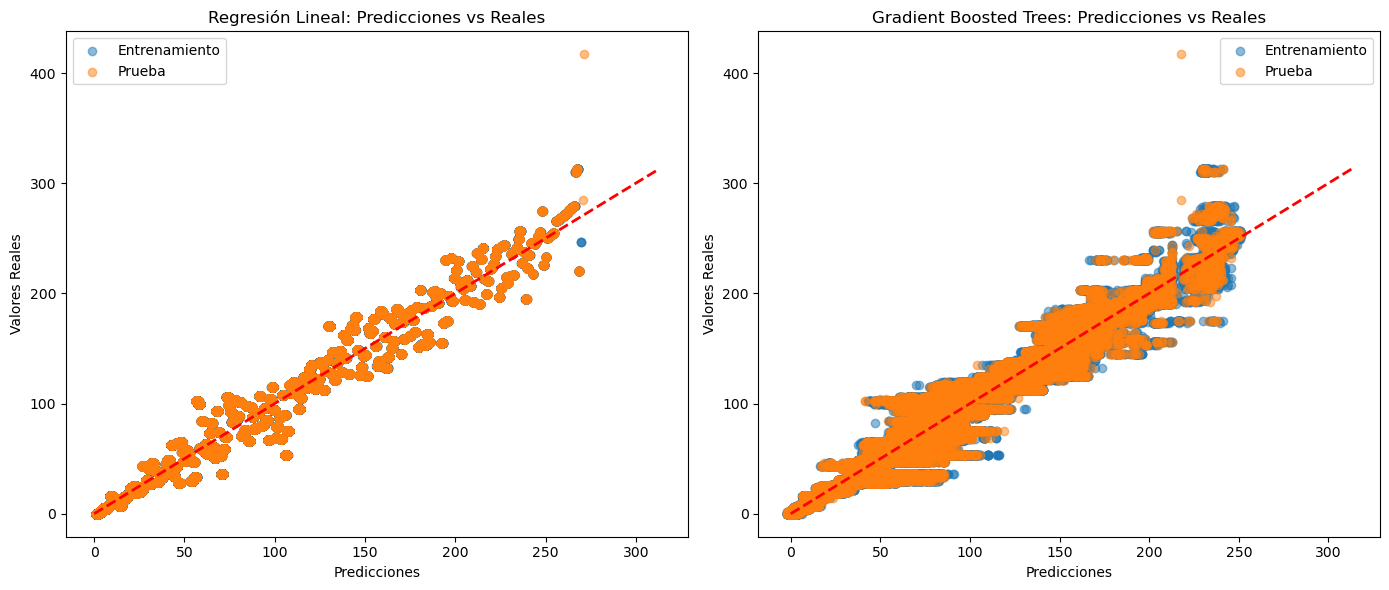

In [ ]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Obtener los valores mínimo y máximo del target para la línea de referencia
target_min = train_data.agg(F.min(target_col)).collect()[0][0]
target_max = train_data.agg(F.max(target_col)).collect()[0][0]

# Convertir predicciones a pandas para graficar
train_preds_lr_pd = train_preds_lr.select("prediction", target_col).toPandas()
test_preds_lr_pd = test_preds_lr.select("prediction", target_col).toPandas()

train_preds_gbt_pd = train_preds_gbt.select("prediction", target_col).toPandas()
test_preds_gbt_pd = test_preds_gbt.select("prediction", target_col).toPandas()

# Graficamos los resultados de ambos modelos
plt.figure(figsize=(14, 6))

# Gráfico para Regresión Lineal
plt.subplot(1, 2, 1)
plt.scatter(train_preds_lr_pd["prediction"], train_preds_lr_pd[target_col], alpha=0.5, label="Entrenamiento")
plt.scatter(test_preds_lr_pd["prediction"], test_preds_lr_pd[target_col], alpha=0.5, label="Prueba")
plt.plot([target_min, target_max], [target_min, target_max], color='red', linestyle='--', linewidth=2)  # Línea ideal de ajuste
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Regresión Lineal: Predicciones vs Reales")
plt.legend()

# Gráfico para Gradient Boosted Trees
plt.subplot(1, 2, 2)
plt.scatter(train_preds_gbt_pd["prediction"], train_preds_gbt_pd[target_col], alpha=0.5, label="Entrenamiento")
plt.scatter(test_preds_gbt_pd["prediction"], test_preds_gbt_pd[target_col], alpha=0.5, label="Prueba")
plt.plot([target_min, target_max], [target_min, target_max], color='red', linestyle='--', linewidth=2)  # Línea ideal de ajuste
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Gradient Boosted Trees: Predicciones vs Reales")
plt.legend()

plt.tight_layout()
plt.show()


El modelo de la derecha refleja overfitting, lo que significa q a pesar de tener mayor precisión, esta mas ajustado a datos de entrenamiento pero menos en prueba. Significa que el modelo ha aprendido demasiado bien los patrones específicos del conjunto de entrenamiento, pero no generaliza bien a nuevos datos

In [ ]:
from scipy.stats import pearsonr

corr, _ = pearsonr(decision_tree_predictions[target_col], decision_tree_predictions["prediction"])
print(f"Coeficiente de correlación de Pearson: {corr:.4f}")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 82, Finished, Available, Finished)

Coeficiente de correlación de Pearson: 0.9725


In [ ]:
from scipy.stats import pearsonr

corr, _ = pearsonr(linear_predictions[target_col], linear_predictions["prediction"])
print(f"Coeficiente de correlación de Pearson: {corr:.4f}")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 83, Finished, Available, Finished)

Coeficiente de correlación de Pearson: 0.9728


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 84, Finished, Available, Finished)

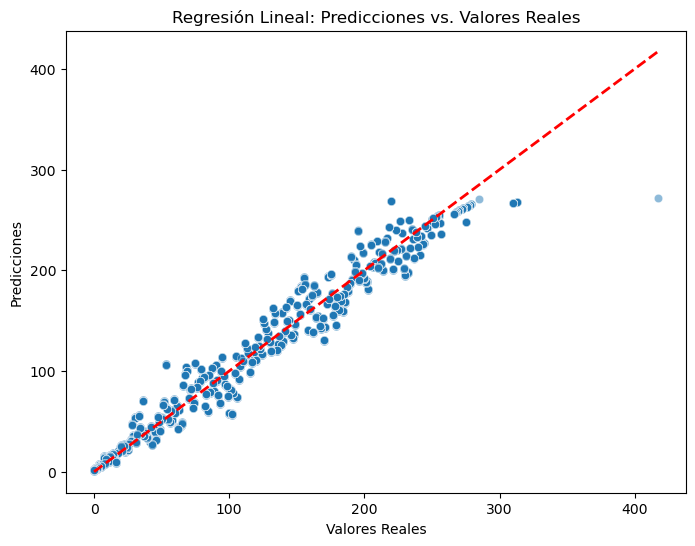

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las predicciones del modelo de regresión lineal
linear_predictions = models["Regresión Lineal"].fit(train_data).transform(test_data).select("prediction", target_col).toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=linear_predictions[target_col], y=linear_predictions["prediction"], alpha=0.5)
plt.plot([linear_predictions[target_col].min(), linear_predictions[target_col].max()],
         [linear_predictions[target_col].min(), linear_predictions[target_col].max()],
         color='red', linestyle='--', linewidth=2)  # Línea ideal de ajuste
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal: Predicciones vs. Valores Reales")
plt.show()


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 85, Finished, Available, Finished)

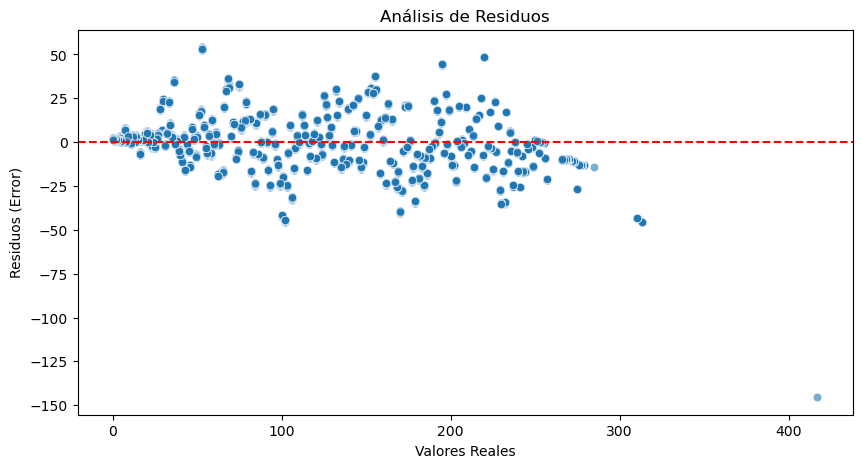

In [ ]:
import seaborn as sns

residuos = linear_predictions["prediction"] - linear_predictions[target_col]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=linear_predictions[target_col], y=residuos, alpha=0.6)
plt.axhline(0, color="red", linestyle="dashed")
plt.xlabel("Valores Reales")
plt.ylabel("Residuos (Error)")
plt.title("Análisis de Residuos")
plt.show()


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 86, Finished, Available, Finished)

/tmp/ipykernel_7385/3721140643.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(linear_predictions[target_col], label="Valores Reales", shade=True)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_7385/3721140643.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(linear_predictions["prediction"], label="Predicciones", shade=True)
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

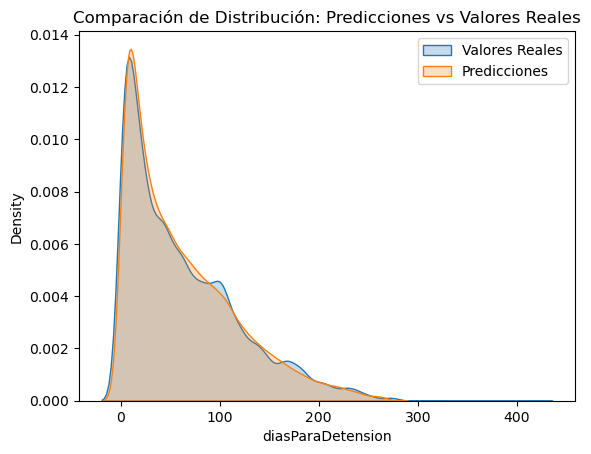

In [ ]:
sns.kdeplot(linear_predictions[target_col], label="Valores Reales", shade=True)
sns.kdeplot(linear_predictions["prediction"], label="Predicciones", shade=True)
plt.legend()
plt.title("Comparación de Distribución: Predicciones vs Valores Reales")
plt.show()


In [ ]:
from pyspark.sql.functions import col, asc, min

predicciones = models["Regresión Lineal"].fit(train_data).transform(test_data)


predicciones_filtradas = predicciones.filter((col("prediction") >= 20) & (col("prediction") <= 30))
predicciones_filtradas = predicciones_filtradas.filter(col("codAlerta") != "SinAlerta")

# Obtener la predicción mínima (más temprana) para cada equipo
predicciones_unicas = (
    predicciones_filtradas
    .groupBy("Equipo")
    .agg(min("prediction").alias("prediction"), min("codAlerta").alias("codAlerta"))
)

predicciones_ordenadas = predicciones_unicas.orderBy(asc("prediction"))

predicciones_ordenadas.show(10, truncate=False)


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 92, Finished, Available, Finished)

+------+------------------+---------+
|Equipo|prediction        |codAlerta|
+------+------------------+---------+
|C327  |20.169637389212998|C452     |
|C320  |21.43459297402329 |C112     |
|C332  |21.960911188115954|C147     |
|C322  |22.399054236497495|C112     |
|C325  |22.892933650949285|C112     |
|C314  |23.51009907295114 |C612     |
|C310  |24.5996597079576  |C112     |
|C317  |24.69668010447577 |C112     |
|C319  |25.66693319643995 |C151     |
|C311  |26.888835751506605|C151     |
+------+------------------+---------+
only showing top 10 rows



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Extraer características y etiquetas desde los DataFrames de Spark
X_train = train_data.select("pca_features").rdd.map(lambda row: row[0]).collect()
y_train = train_data.select(target_col).rdd.map(lambda row: row[0]).collect()


X_train_np = np.array(X_train).tolist()
y_train_np = np.array(y_train)

# Modelo de Regresión Lineal
modelo = LinearRegression()

cv_scores = cross_val_score(modelo, X_train_np, y_train_np, scoring="r2", cv=5)

print(f"✅ R² en validación cruzada: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


StatementMeta(, 8e7dc2ef-0fbd-44c4-88d7-e7c23171de12, 88, Finished, Available, Finished)

✅ R² en validación cruzada: 0.9357 ± 0.0174
